# **Dataset**

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/ATDMC/ATDMC_DA.csv')
df.head(10)

,Name,Domain,Passion,Skills
0,Akalya,AI&DS,Design,"Programming, AutoCAD, Data Science"
1,Hindu,EEE,Embedded Systems,"Programming, IoT, Matlab"
2,Hiranya,EEE,Semiconductor,"Programming, Matlab"
3,Subhashini,EEE,Electrical Engineer,"Programming, Data Analysis, Testing, PLC"
4,Madhuri,MECH,Automotive Engineering,"Programming, Solidworks"
5,Sharmila,MECH,Research,"Programming, AutoCAD, Solidworks"
6,Divya,CSE,Data Analyst,"Programming, Web Development, Data Analysis"
7,Jeyavarshini,ECE,Communication Systems,"Web Development, IoT, Programming"
8,Lavanya,CSE,Developer,"Programming, Web Development"
9,Kumari,CSE,Developer,"Programming, Web Development"


# **Exploratory Data Analysis**

## **Skills and Passion Distribution across Students**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

/tmp/ipython-input-6-379218543.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=skill_df, palette='viridis')


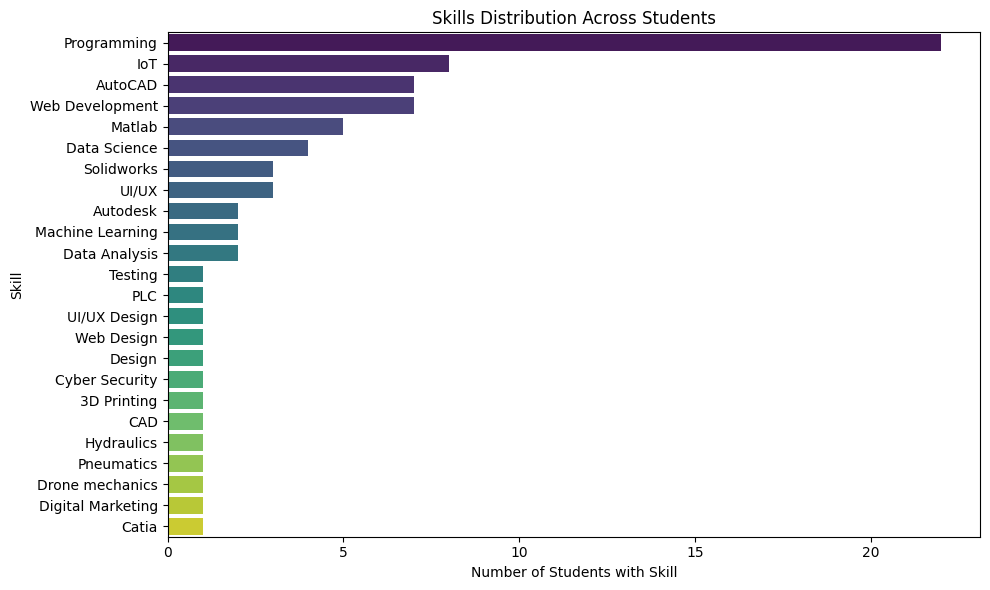

In [ ]:
# Split and clean skills
all_skills = []
for skills in df['Skills']:
    if pd.notnull(skills):
        individual_skills = [skill.strip() for skill in skills.split(',')]
        all_skills.extend(individual_skills)

# Count skill frequency
skill_counts = Counter(all_skills)
skill_df = pd.DataFrame(skill_counts.items(), columns=['Skill', 'Count']).sort_values(by='Count', ascending=False)

# Plot skill distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Skill', data=skill_df, palette='viridis')
plt.title('Skills Distribution Across Students')
plt.xlabel('Number of Students with Skill')
plt.ylabel('Skill')
plt.tight_layout()
plt.show()

/tmp/ipython-input-9-3918262946.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Passion', data=skill_df, palette='viridis')


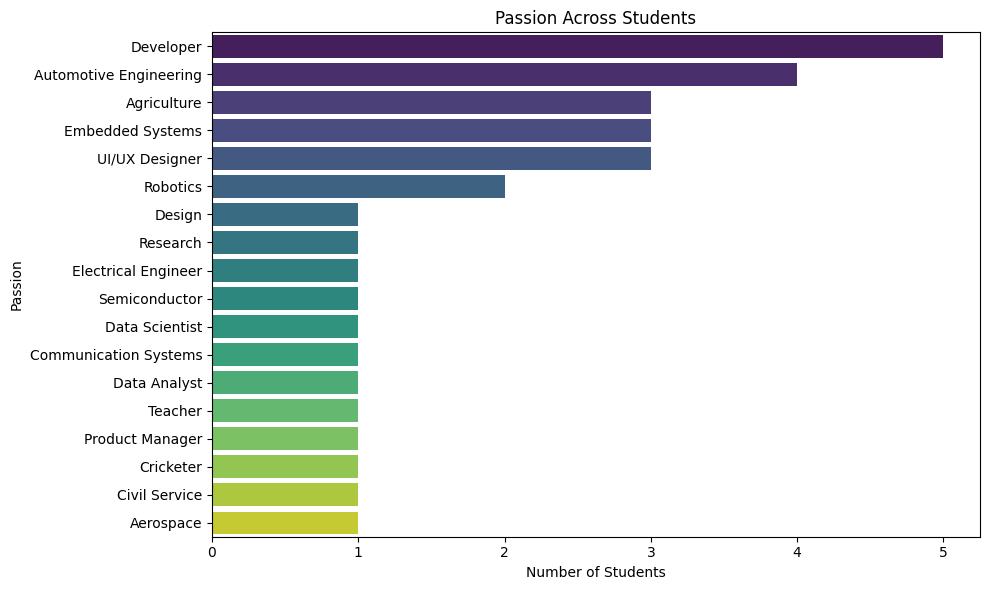

In [ ]:
# Split and clean skills
all_skills = []
for skills in df['Passion']:
    if pd.notnull(skills):
        individual_skills = [skill.strip() for skill in skills.split(',')]
        all_skills.extend(individual_skills)

# Count skill frequency
skill_counts = Counter(all_skills)
skill_df = pd.DataFrame(skill_counts.items(), columns=['Passion', 'Count']).sort_values(by='Count', ascending=False)

# Plot skill distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Passion', data=skill_df, palette='viridis')
plt.title('Passion Across Students')
plt.xlabel('Number of Students')
plt.ylabel('Passion')
plt.tight_layout()
plt.show()

## **Skills to Passion Gap Analysis**

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


# Preprocess skills: remove extra spaces, join as sentence
df['Skills_clean'] = df['Skills'].apply(lambda x: ' '.join([skill.strip().lower() for skill in x.split(',')]))

# Preprocess passion: lowercase text
df['Passion_clean'] = df['Passion'].str.lower()

# Combine both for vectorization
combined_texts = df['Skills_clean'].tolist() + df['Passion_clean'].tolist()

# TF-IDF vectorization
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(combined_texts)

# Split TF-IDF back into skills and passions
skills_vectors = tfidf_matrix[:len(df)]
passion_vectors = tfidf_matrix[len(df):]

# Compute cosine similarity between each student's skills and their passion
similarity_scores = cosine_similarity(skills_vectors, passion_vectors)
df['Skill_Passion_Alignment_Score'] = np.diag(similarity_scores)

# Normalize for readability (optional)
df['Alignment_%'] = (df['Skill_Passion_Alignment_Score'] * 100).round(2)

# Determine gap level (just an example rule)
def label_gap(score):
    if score > 0.5:
        return 'Aligned'
    elif score > 0.2:
        return 'Partial Gap'
    else:
        return 'Significant Gap'

df['Gap_Label'] = df['Skill_Passion_Alignment_Score'].apply(label_gap)

# Show result
gap = df[['Name', 'Skills', 'Passion', 'Alignment_%', 'Gap_Label']]
gap.head(30)

aligned = gap[(gap['Gap_Label'] == 'Aligned')| (gap['Gap_Label'] == 'Partial Gap')]
print(aligned[['Name','Gap_Label','Alignment_%']])

              Name    Gap_Label  Alignment_%
6            Divya  Partial Gap        23.76
11          Sathya  Partial Gap        32.48
12           Sadha  Partial Gap        43.61
13         Pavitra      Aligned        51.22
29  Kiruba Shankar      Aligned        68.54


# **ML Modelling**

## Skill Clustering

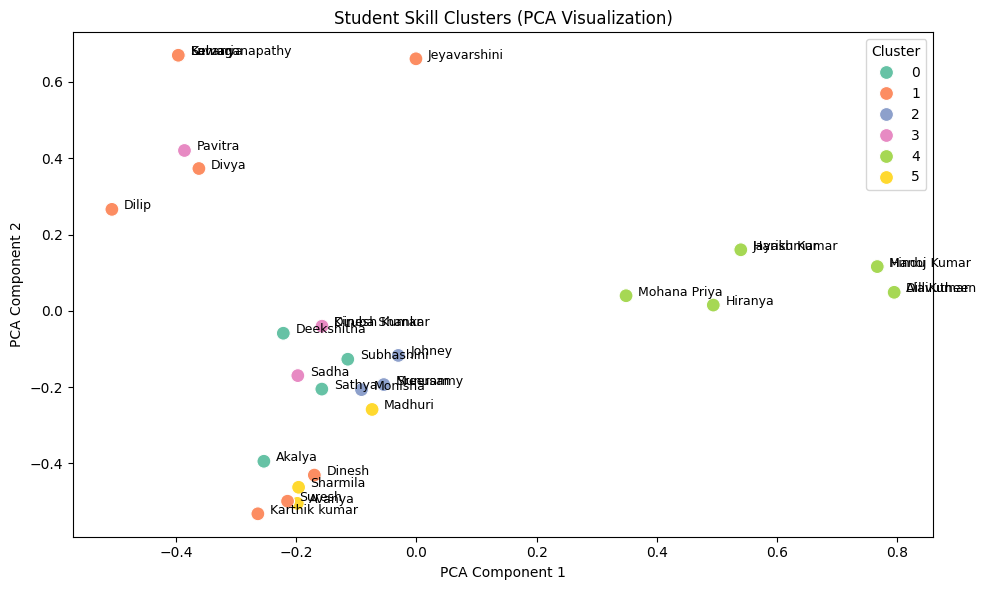

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocess skills
df['Skills_clean'] = df['Skills'].fillna('').apply(lambda x: ' '.join([skill.strip().lower() for skill in x.split(',')]))

# TF-IDF vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Skills_clean'])

# KMeans clustering
k = 6  # you can change this based on your dataset size
kmeans = KMeans(n_clusters=k, random_state=42)
df['Skill_Cluster'] = kmeans.fit_predict(X)

# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Skill_Cluster', data=df, palette='Set2', s=100)

# Annotate student names (optional)
for i, row in df.iterrows():
    plt.text(row['PCA1'] + 0.02, row['PCA2'], row['Name'], fontsize=9)

plt.title('Student Skill Clusters (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

In [ ]:
# Create a function to get top N skills in a cluster
def top_skills_by_cluster(df, cluster_col='Skill_Cluster', skill_col='Skills_clean', top_n=5):
    cluster_skills = {}
    for cluster in sorted(df[cluster_col].unique()):
        skills_list = df[df[cluster_col] == cluster][skill_col]
        all_skills = []
        for skills in skills_list:
            all_skills.extend(skills.split())
        common_skills = Counter(all_skills).most_common(top_n)
        cluster_skills[cluster] = [skill for skill, _ in common_skills]
    return cluster_skills

# Get top skills for each cluster
cluster_keywords = top_skills_by_cluster(df)
for k, skills in cluster_keywords.items():
    print(f"Cluster {k}: {', '.join(skills)}")

Cluster 0: programming, data, science, autocad, analysis
Cluster 1: web, development, programming, autocad, autodesk
Cluster 2: machine, learning, programming, cyber, security
Cluster 3: programming, ui/ux, data, science, design
Cluster 4: iot, programming, matlab, design
Cluster 5: solidworks, programming, autocad, catia


## **Student Domain Classifier Based on Skills**

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

# Preprocess skills column
df['Skills_clean'] = df['Skills'].fillna('').apply(lambda x: ' '.join([s.strip().lower() for s in x.split(',')]))

# Encode domain labels
label_encoder = LabelEncoder()
df['Domain_Label'] = label_encoder.fit_transform(df['Domain'])

# TF-IDF vectorization of skills
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Skills_clean'])

# Target variable
y = df['Domain_Label']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier (Linear SVM here, but others like RandomForest also work)
clf = LinearSVC()
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
all_labels = label_encoder.transform(label_encoder.classes_)
print(classification_report(y_test, y_pred, labels=all_labels, target_names=label_encoder.classes_))

Accuracy: 0.5714285714285714

Classification Report:

              precision    recall  f1-score   support

       AI&DS       1.00      1.00      1.00         1
         CSE       0.00      0.00      0.00         3
         ECE       0.00      0.00      0.00         0
         EEE       1.00      1.00      1.00         2
        MECH       1.00      1.00      1.00         1
MECHATRONICS       0.00      0.00      0.00         0

    accuracy                           0.57         7
   macro avg       0.50      0.50      0.50         7
weighted avg       0.57      0.57      0.57         7



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me